##Installation


In [ ]:
!pip install keras
!pip install tensorflow
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import Libraries


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.utils 
import numpy as np
from PIL import Image
import os

import matplotlib.pyplot as plt
import pandas as pd
import keras
import cv2
import os
import math
import splitfolders
import itertools

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array,load_img
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
#import gradio
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


##Upload/Connect Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
input_dataset=('/content/drive/MyDrive/3 kinds of Pneumonia(dataset)(new)')

Mounted at /content/drive


#Dataset Analysis

In [ ]:
number_of_images = {}

for dir in os.listdir(input_dataset):
  number_of_images[dir] = len(os.listdir(os.path.join(input_dataset,dir)))

number_of_images.items()


dict_items([('COVID-19', 2000), ('Normal', 2000), ('Pneumonia-Viral', 2000), ('Pneumonia-Bacterial', 2000)])

##Splitting Dataset into Train, Validation and test

In [ ]:
from splitfolders.split import group_by_prefix
splitfolders.ratio(input_dataset,output="dataset",seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 8000 files [02:13, 59.81 files/s] 


#5.VGG16 MODEL


##Data Pre-processing of VGG16 Model

In [ ]:
from keras.utils.image_dataset import image_dataset_from_directory
from keras.applications.vgg16 import preprocess_input as p5
def preprocessing_train5(path):
  image_data=ImageDataGenerator(preprocessing_function=p5,zoom_range=0.2,shear_range=0.2,horizontal_flip=True,vertical_flip=False)#data augmentation
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode="categorical")
  
  return image

In [ ]:
path_tr5='/content/dataset/train'
train_data=preprocessing_train5(path_tr5)#pre-processing training dataset

Found 5600 images belonging to 4 classes.


In [ ]:
def preprocessing5(path):
  image_data=ImageDataGenerator(preprocessing_function=p5)#data augmentation
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode="categorical")
  
  return image

In [ ]:
path_v5='/content/dataset/val'
val_data=preprocessing5(path_v5)#pre-processing validation dataset

Found 1600 images belonging to 4 classes.


In [ ]:
path_test5='/content/dataset/test'
test_data=preprocessing5(path_test5)#pre-processing validation dataset

Found 800 images belonging to 4 classes.


In [ ]:
x_test, y_test = [], []
for i in range(len(test_data)):
    batch_x, batch_y = test_data[i]
    x_test.append(batch_x)
    y_test.append(batch_y)

# Concatenate the batches to obtain the final x_train and y_train arrays
x_test = tf.concat(x_test, axis=0)
y_test = tf.concat(y_test, axis=0)

# Print the shape of the x_train and y_train arrays
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_test shape: (800, 224, 224, 3)
y_test shape: (800, 4)


##VGG16 Model Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input,Flatten, Dense
from keras.models import Model,load_model,Sequential
from keras.applications.vgg16 import VGG16

In [ ]:
vgg=VGG16(input_shape=(224,224,3),weights='imagenet', include_top=False)
vgg.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
x=Flatten()(vgg.output)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=4, activation='softmax')(x)

# prevent the weights from being updated during training
#vgg.trainable = False

vgg_model=Model(vgg.input,x)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
vgg_model.compile(optimizer = "adam" , 
            loss = 'categorical_crossentropy' , 
            metrics = ['accuracy'])


##VGG16 Model Early Stop and Model Check Point

In [ ]:
es5=EarlyStopping(monitor="val_accuracy",verbose=1, patience=10, mode="max")

#Model check point
mc5= ModelCheckpoint(monitor="val_accuracy", filepath="./Best_model5.h5", verbose=1, save_best_only=True, mode="max")
reduce_lr5 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.000000001)

cb5=[es5,mc5,reduce_lr5]


In [ ]:
m5=vgg_model.fit(train_data,steps_per_epoch=len(train_data),epochs=100,verbose=1,validation_data=(val_data),validation_steps=len(val_data),callbacks=cb5)

Epoch 1/100
175/175 [==============================] - ETA: 0s - loss: 5.2629 - accuracy: 0.7457
Epoch 1: val_accuracy improved from -inf to 0.80313, saving model to ./Best_model5.h5
175/175 [==============================] - 42s 203ms/step - loss: 5.2629 - accuracy: 0.7457 - val_loss: 1.0788 - val_accuracy: 0.8031 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.8716
Epoch 2: val_accuracy improved from 0.80313 to 0.81750, saving model to ./Best_model5.h5
175/175 [==============================] - 34s 197ms/step - loss: 0.4438 - accuracy: 0.8716 - val_loss: 0.7972 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9180
Epoch 3: val_accuracy improved from 0.81750 to 0.83688, saving model to ./Best_model5.h5
175/175 [==============================] - 34s 197ms/step - loss: 0.2389 - accuracy: 0.9180 - val_loss: 0.6478 - val_accuracy: 0.8369 - lr: 0.0010
Epoc

##Graphical implementation of VGG16

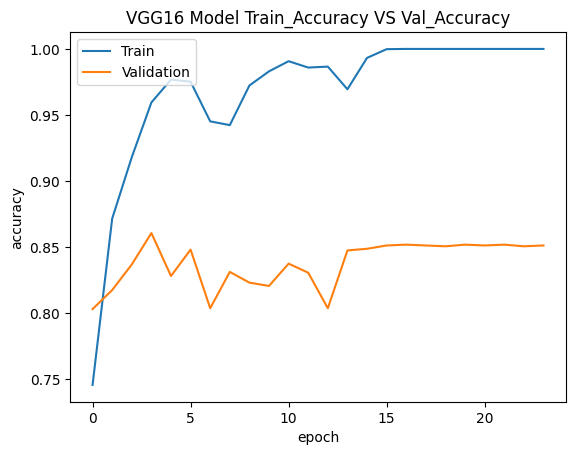

In [ ]:
plt.plot(m5.history['accuracy'])
plt.plot(m5.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.title("VGG16 Model Train_Accuracy VS Val_Accuracy")
plt.show()

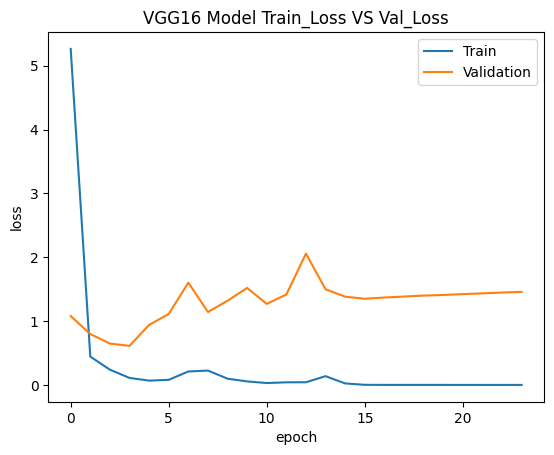

In [ ]:
plt.plot(m5.history['loss'])
plt.plot(m5.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.title("VGG16 Model Train_Loss VS Val_Loss")
plt.show()

##VGG16 Model Accuracy and Loss


In [ ]:
model5=load_model('/content/Best_model5.h5')

In [ ]:
loss_vgg,acc_vgg=model5.evaluate(x_test,y_test)
print(f"The accuracy of VGG16 model is {acc_vgg*100} % and loss is {loss_vgg}")

25/25 [==============================] - 4s 131ms/step - loss: 0.4956 - accuracy: 0.8612
The accuracy of VGG16 model is 86.12499833106995 % and loss is 0.4956279695034027


##VGG16 Model Percision, Recall, F1 Score


In [ ]:
y_pred = model5.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculating the confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

25/25 [==============================] - 7s 290ms/step


In [ ]:
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.96      0.97      0.97       200
           2       0.77      0.70      0.73       200
           3       0.72      0.79      0.75       200

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



Normalized confusion matrix


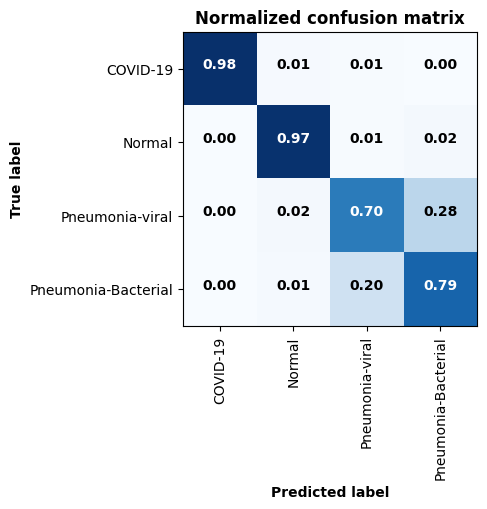

In [ ]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix without normalization")
  
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title,weight='bold')
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=90)
  plt.yticks(tick_marks,classes)


  fmt='.2f' if normalize else 'd'
  thresh=cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',weight='bold',
             color='white' if cm[i,j]> thresh else 'black')
  plt.tight_layout()
  plt.ylabel("True label", weight='bold')
  plt.xlabel("Predicted label",weight="bold")

#compute confusion matrix
cnf_matrix=confusion_matrix(y_true_classes, y_pred_classes)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['COVID-19','Normal','Pneumonia-viral','Pneumonia-Bacterial'],normalize=True,title="Normalized confusion matrix")
plt.show()